# Gradient Boosting Regressor Analysis

### 1. Importing Libraries

In [6]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### 2. Data Loading

In [7]:
train_df = pd.read_csv('train.csv')
val_df = pd.read_csv('val.csv')
test_df = pd.read_csv('test.csv')

df = pd.concat([train_df, val_df, test_df], ignore_index=True)

### 3. Data Preprocessing

In [8]:
df['evapotranspiration'].interpolate(method='linear', inplace=True)
df['soilmoisture'].interpolate(method='linear', inplace=True)

df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['dayofweek'] = df['date'].dt.dayofweek
df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)

df = shuffle(df, random_state=42)

X = df.drop(columns=['inflow', 'date'])
y = df['inflow']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
train_size = len(train_df)
val_size = len(val_df)

X_train_scaled = X_scaled[:train_size]
X_val_scaled = X_scaled[train_size:train_size+val_size]
X_test_scaled = X_scaled[train_size+val_size:]

y_train = y[:train_size]
y_val = y[train_size:train_size+val_size]
y_test = y[train_size+val_size:]

### 4. Hyperparameter Tuning

In [9]:
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.001, 0.01, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10]
}

gbr = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(gbr, param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)

best_model = grid_search.best_estimator_

Fitting 3 folds for each of 108 candidates, totalling 324 fits


### 5. Model Evaluation

In [10]:
y_val_pred = best_model.predict(X_val_scaled)
val_r2 = r2_score(y_val, y_val_pred)
val_mae = mean_absolute_error(y_val, y_val_pred)

y_test_pred = best_model.predict(X_test_scaled)
test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print("\nValidation Results:")
print(f"R² score: {val_r2:.4f}")
print(f"Mean Absolute Error: {val_mae:.4f}")

print("\nTest Results:")
print(f"R² score: {test_r2:.4f}")
print(f"Mean Absolute Error: {test_mae:.4f}")


Validation Results:
R² score: -0.1314
Mean Absolute Error: 2713.0166

Test Results:
R² score: 0.0853
Mean Absolute Error: 3711.5996


### 6. Feature Importance

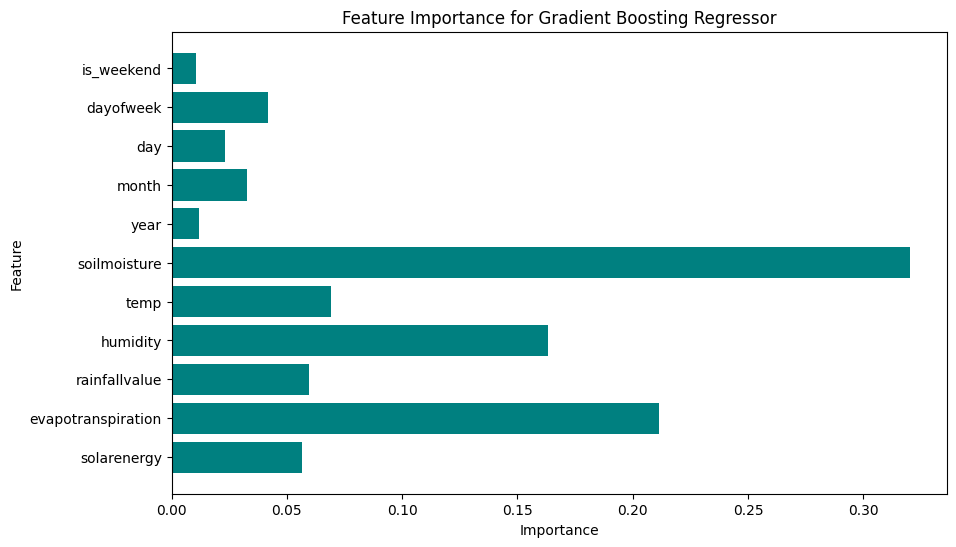

In [11]:
feature_importances = best_model.feature_importances_
features = X.columns

plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances, color='teal')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Gradient Boosting Regressor')
plt.savefig('figures/feature_importance.png')
plt.show()

### 7. Data Visualization

#### 7.1 Heat Map

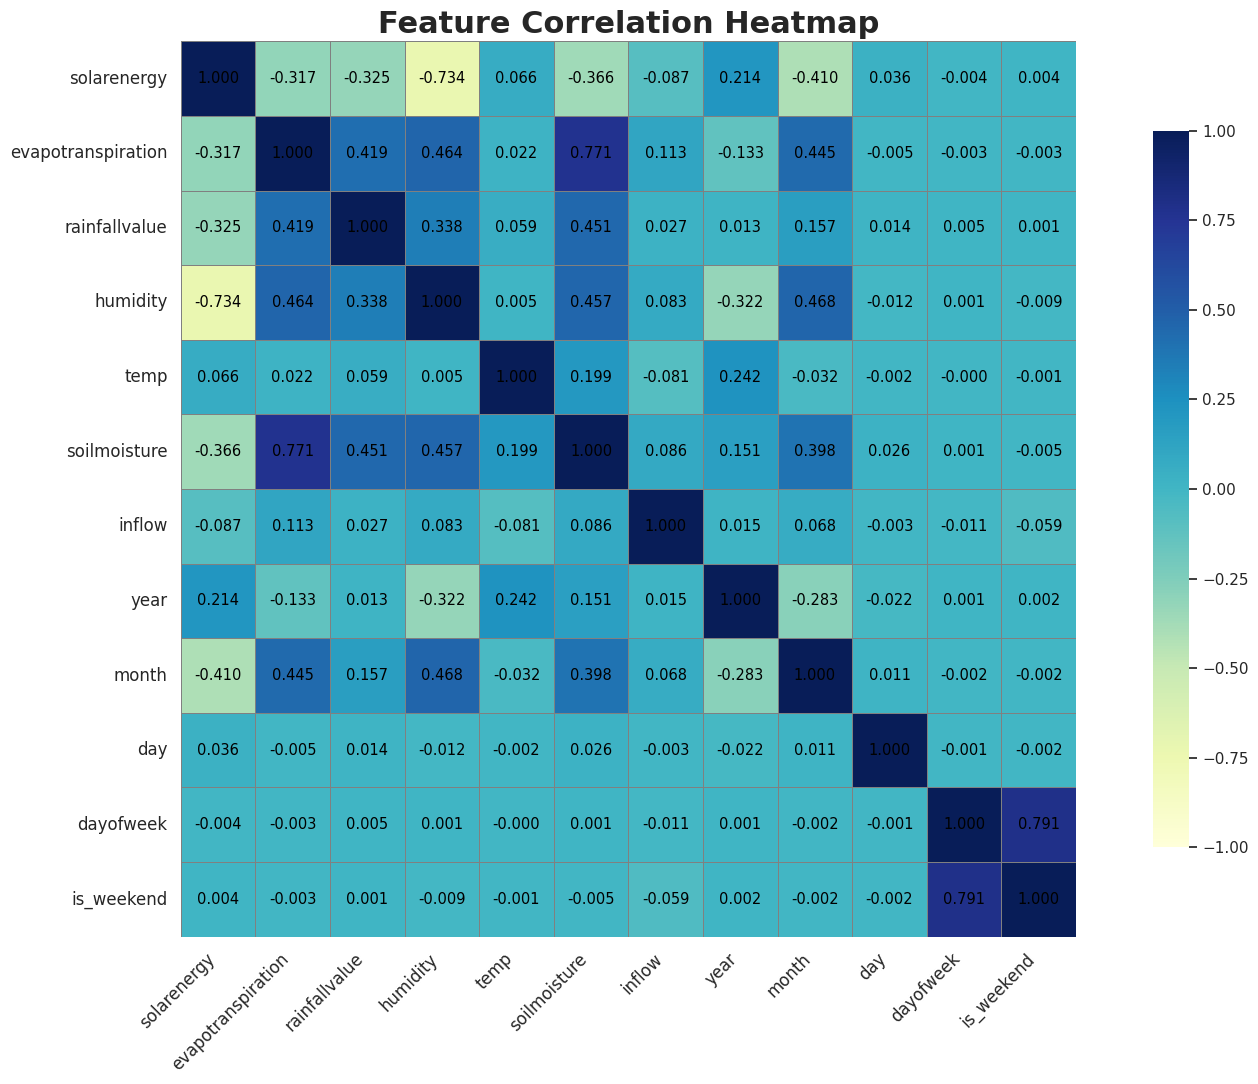

In [12]:
plt.figure(figsize=(16,11))
sns.set_theme(style='whitegrid')
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, 
            annot=True, 
            fmt=".3f", 
            cmap='YlGnBu',
            square=True, 
            linewidths=0.5, 
            linecolor='gray', 
            cbar_kws={"shrink": .8, "orientation": "vertical"}, 
            annot_kws={"size": 10.5, "color": "black"},  
            vmin=-1, vmax=1) 
plt.title('Feature Correlation Heatmap', fontsize=22, weight='bold')
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()  
plt.show()

#### 7.2  Feature Distribution

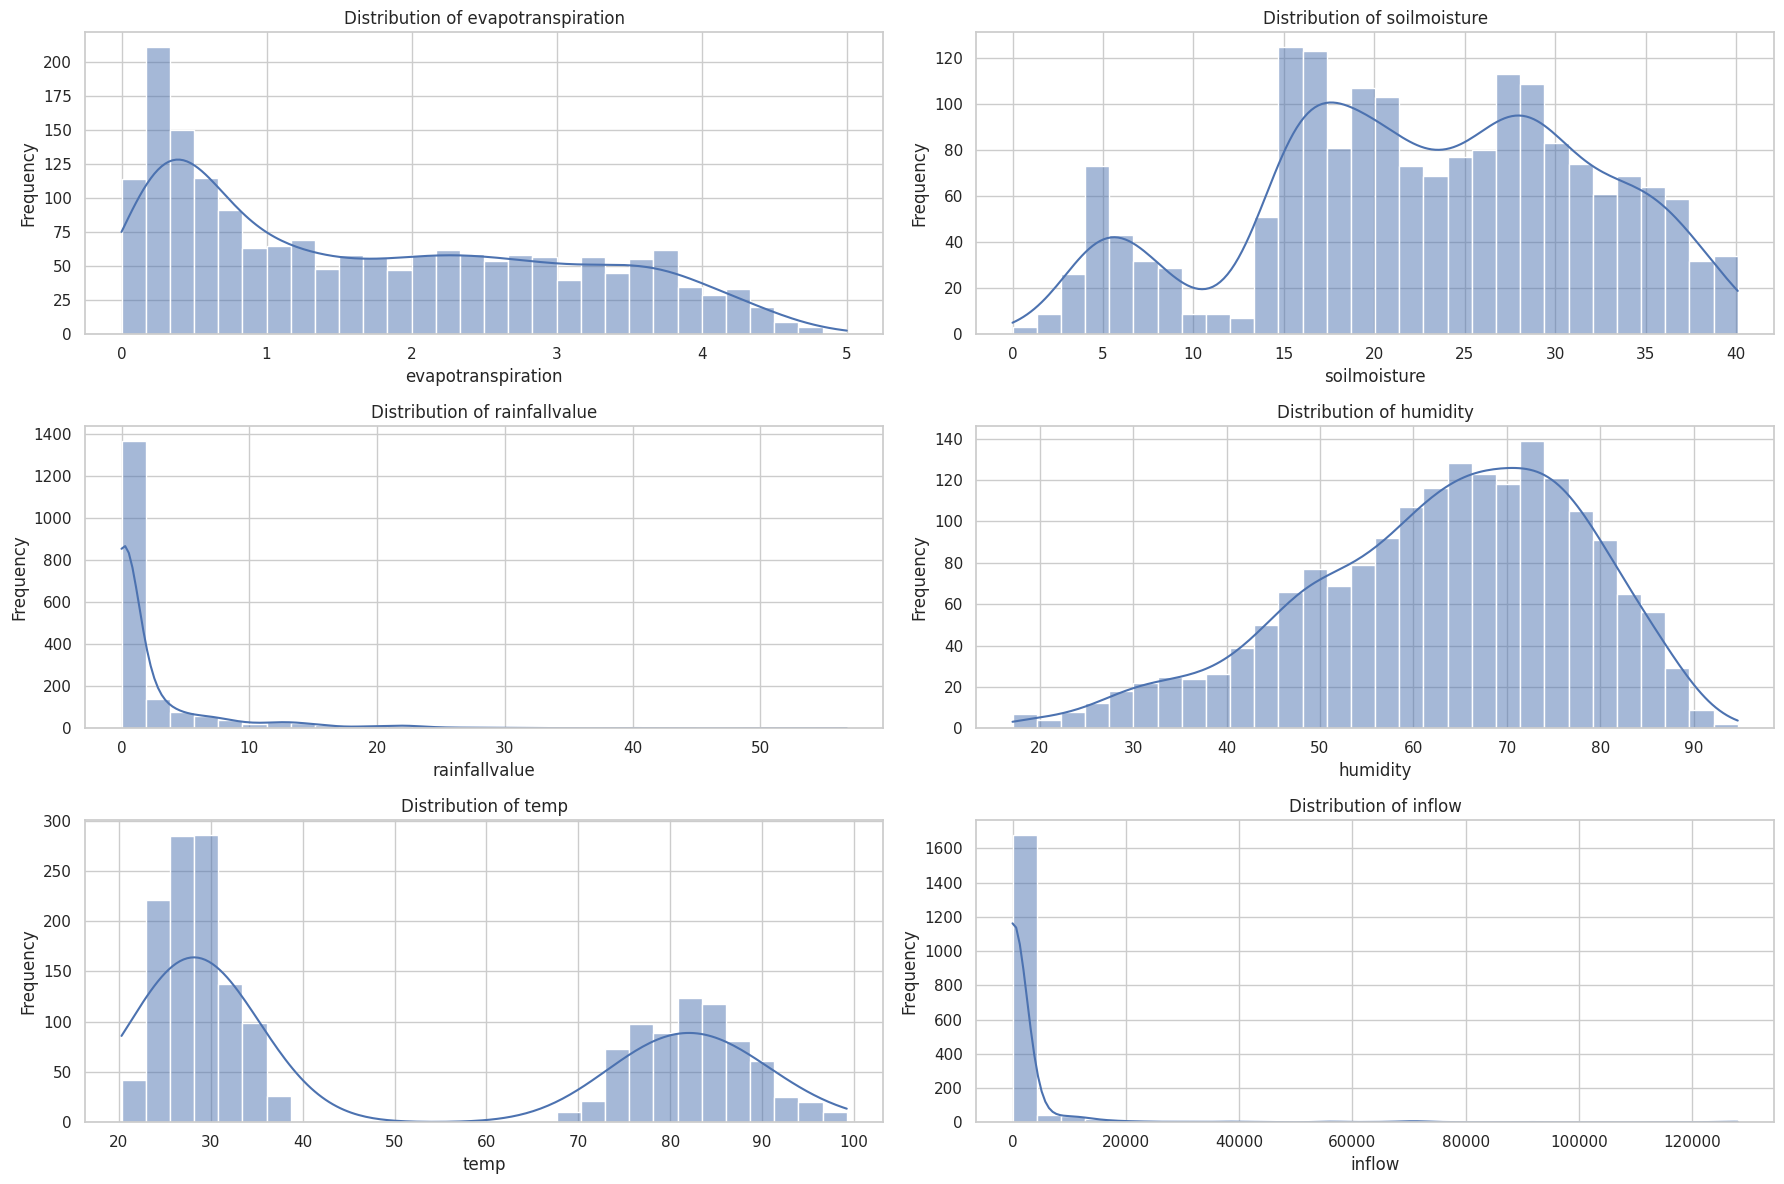

In [13]:
subset_features = ['evapotranspiration', 'soilmoisture', 'rainfallvalue', 'humidity', 'temp', 'inflow']
plt.figure(figsize=(18, 12))
for i, feature in enumerate(subset_features):
    plt.subplot(3, 2, i+1) 
    sns.histplot(df[feature], bins=30, kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

#### 7.3   Box Plot

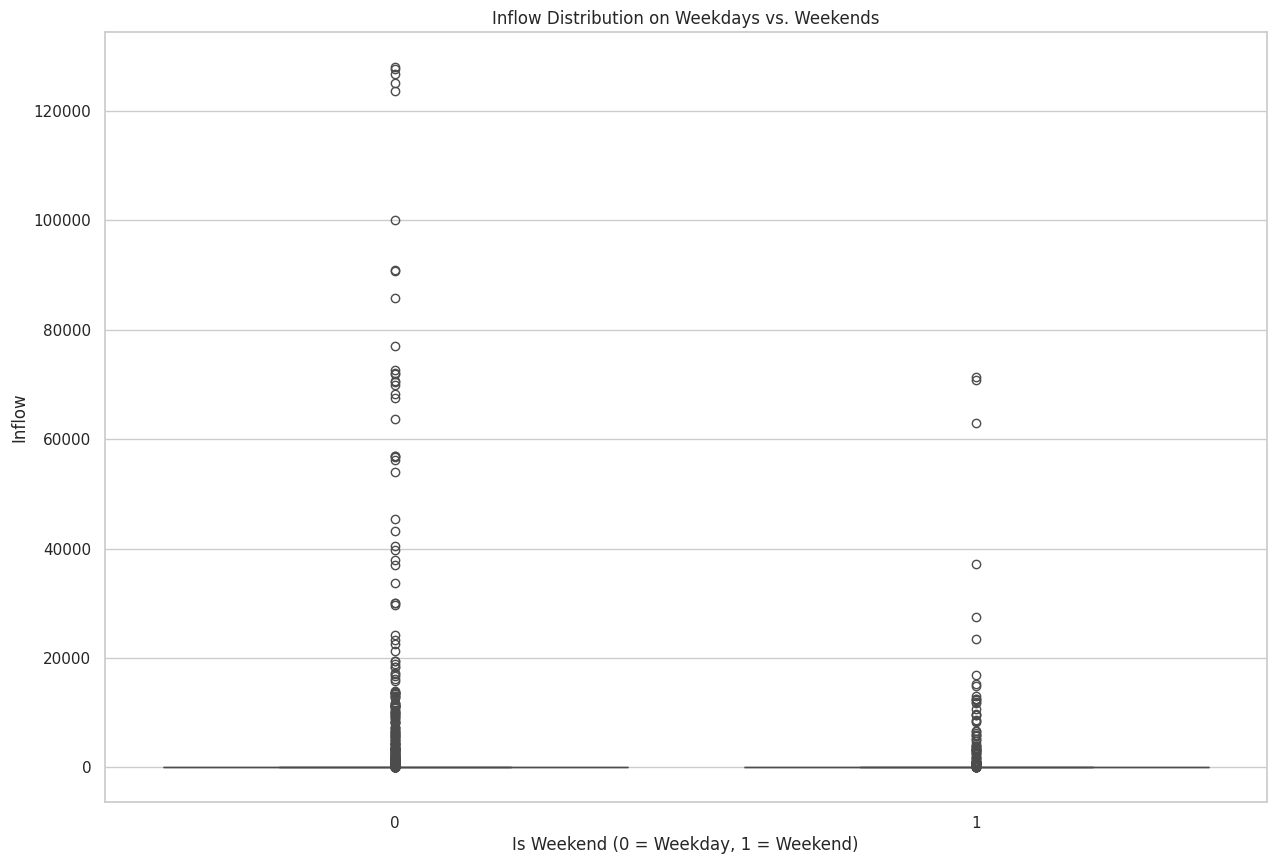

In [14]:
plt.figure(figsize=(15, 10))
sns.boxplot(x='is_weekend', y='inflow', data=df)
plt.title('Inflow Distribution on Weekdays vs. Weekends')
plt.xlabel('Is Weekend (0 = Weekday, 1 = Weekend)')
plt.ylabel('Inflow')
plt.show()

### 8. Actual vs Predicted 

#### 8.1  Validation DataSet

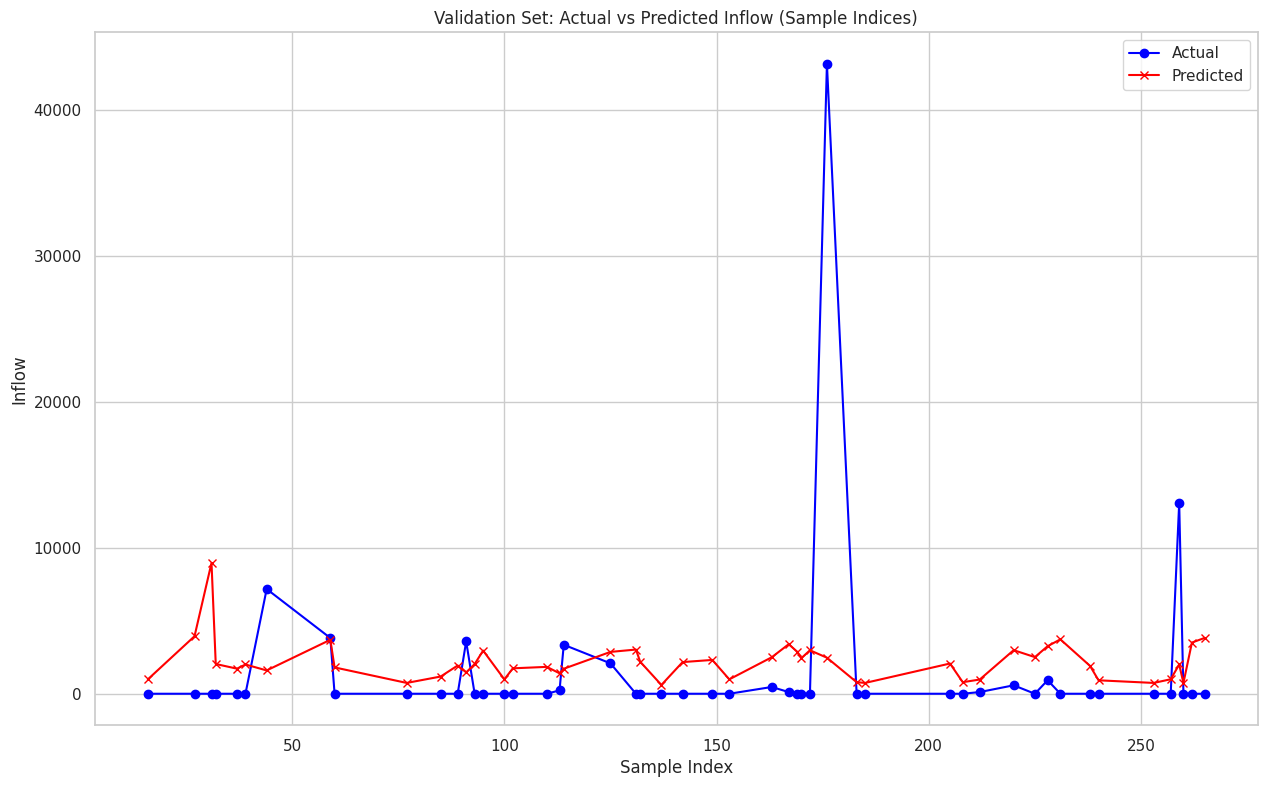

In [15]:
sample_indices_val = np.random.choice(range(len(y_val)), size=50, replace=False)
sample_indices_val.sort()  

plt.figure(figsize=(15, 9))
plt.plot(sample_indices_val, y_val.iloc[sample_indices_val], 'o-', label='Actual', color='blue') 
plt.plot(sample_indices_val, y_val_pred[sample_indices_val], 'x-', label='Predicted', color='red') 
plt.xlabel('Sample Index')
plt.ylabel('Inflow')
plt.title('Validation Set: Actual vs Predicted Inflow (Sample Indices)')
plt.legend()
plt.savefig('figures/validation_sample_actual_vs_pred_connected.png')
plt.show()

#### 8.2  Test Dataset

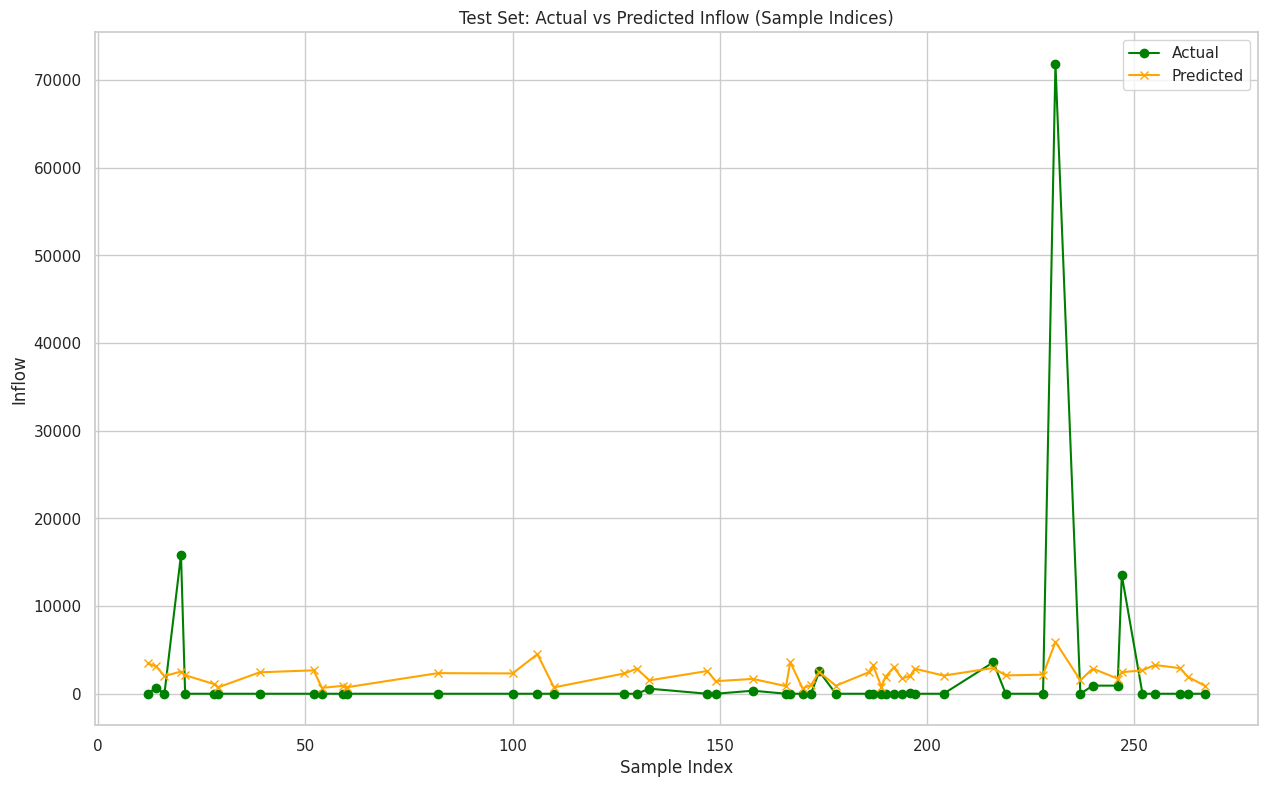

In [16]:
sample_indices_test = np.random.choice(range(len(y_test)), size=50, replace=False)
sample_indices_test.sort()

plt.figure(figsize=(15, 9))
plt.plot(sample_indices_test, y_test.iloc[sample_indices_test], 'o-', label='Actual', color='green')  
plt.plot(sample_indices_test, y_test_pred[sample_indices_test], 'x-', label='Predicted', color='orange')  
plt.xlabel('Sample Index')
plt.ylabel('Inflow')
plt.title('Test Set: Actual vs Predicted Inflow (Sample Indices)')
plt.legend()
plt.savefig('figures/test_sample_actual_vs_pred_connected.png')
plt.show()

### 9.  Mean Absolute Error ( MAE ) Comparison

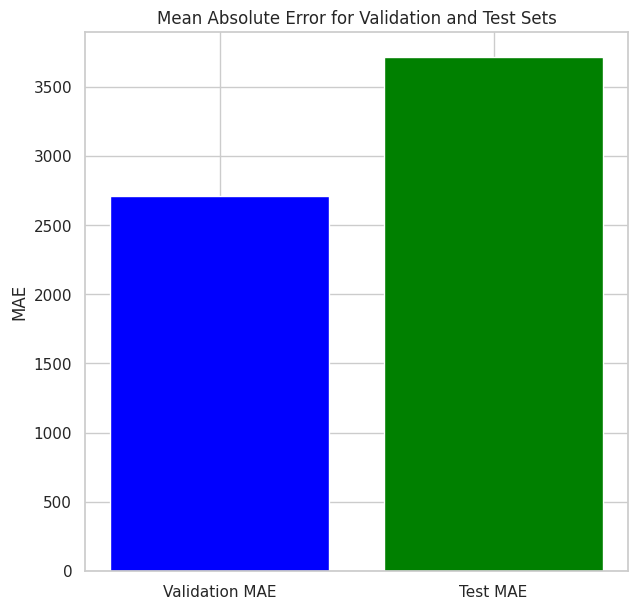

In [54]:
plt.figure(figsize=(7, 7))
plt.bar(['Validation MAE', 'Test MAE'], [val_mae, test_mae], color=['blue', 'green'])
plt.title('Mean Absolute Error for Validation and Test Sets')
plt.ylabel('MAE')
plt.show()